In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/nfs/users/nfs_e/er10/fonts/arial.ttf',
    name='my_arial')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'

import seaborn as sns
import pandas as pd
import pysam
from liftover import get_lifter
import tabix
import myvariant
mv = myvariant.MyVariantInfo()

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()


%matplotlib inline

In [3]:
data_root='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Revised/'
out_files='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots/'

df=pd.read_csv(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', header=0, sep='\t',index_col=False)
not_snvre=df.query('Variant_design_type!="snvre"')
snv=df.query('Variant_design_type!="snv"')


SGE_oligo_name
Variant_design_type
chrom
VCF_position
VCF_Ref
VCF_Alt
ref_codon
alt_codon
ref_aa
alt_aa
Amino_acids
Primary_consequence
Consequence
Variant_category
cDNA_position
CDS_position
Protein_position
Simplified_protein_pos
EXON
INTRON
SGE_exon_group
D7_combined_LFC
D11_combined_LFC
D15_combined_LFC
D21_combined_LFC
cLFCd7_BH_FDR
cLFCd11_BH_FDR
cLFCd15_BH_FDR
cLFCd21_BH_FDR
cLFC_trend
cLFC_trend_BH_FDR
SGE_functional_classification
Category_for_RF
mean_SASA
SASA_cat
Distance_to_core
Scorecons_aa_conservation
DeltaDeltaG
revel
SIFT_numeric
PolyPhen_numeric
CADD_PHRED
SpliceAI_Delta_score
Clinically_reported_variant
Population_database
GnomAD_maxAF
UKBB_AF
SGE_prediction_of_variant_function_in_NDD_context
SGE_prediction_of_variant_function_in_NDD_context.1
Posterior_probability_variant_is_functionally_normal
Posterior_probability_variant_is_functionally_abnormal_of_NDD_relevance
Confidence_of_functionally_abnormal_variant_prediction


In [69]:
sex_agnostic_clinical_vars={}
female_path_all={}
female_path_denovo={}
male_path_all={}
male_path_denovo={}

with open(data_root+'Supp_Table13_DDX3X_all_clinical_variants.txt', 'r') as f:
    header=f.readline().strip().split("\t")
    print(header)
    pos38_col=header.index('hg38_pos')    
    ref_col=header.index('ref')
    alt_col=header.index('alt')
    source_col=header.index('reported_in')
    ID_col=header.index('ID')
    inh_col=header.index('inheritance')
    path_col=header.index('pathogenicity')
    sex_col=header.index('sex')
    DC_col=header.index('SGE_functional_classification')
    lines=f.readlines()
    for line in lines:
        fields=line.strip().split("\t")
        hg38_pos=int(fields[pos38_col].strip())
        ref=fields[ref_col].strip()
        alt=fields[alt_col].strip()
        source=fields[source_col].strip()
        inh=fields[inh_col].strip()
        proband_ID = fields[ID_col].strip()
        sex=fields[sex_col].strip()
        path = fields[path_col].strip()
        dc = fields[DC_col].strip()
        if 'not_interpreted' in path:
            sex_agnostic_clinical_vars[(hg38_pos, ref, alt)] = ('not_interpreted',inh, dc)
        elif 'Uncertain_significance' in path:
            sex_agnostic_clinical_vars[(hg38_pos, ref, alt)] = ('Uncertain_significance',inh, dc)
        elif 'athogenic' in path:
            if 'Conflicting' not in path:
                sex_agnostic_clinical_vars[(hg38_pos, ref, alt)] = ('Pathogenic/Likely_pathogenic',inh, dc)                
                if 'female' in sex:
                    female_path_all[(hg38_pos, ref, alt)] = ('Pathogenic/Likely_pathogenic',inh, dc)
                    if 'denovo' in inh:
                        female_path_denovo[(hg38_pos, ref, alt)] = ('Pathogenic/Likely_pathogenic',inh, dc)
                elif 'male' in sex:
                    male_path_all[(hg38_pos, ref, alt)] = ('Pathogenic/Likely_pathogenic',inh, dc)
                    if 'denovo' in inh:
                        male_path_denovo[(hg38_pos, ref, alt)] = ('Pathogenic/Likely_pathogenic',inh, dc)
        elif 'enign' in path:
            try:
                print('benign variant already in dict as ', sex_agnostic_clinical_vars[(hg38_pos, ref, alt)])
            except KeyError:
                pass
            sex_agnostic_clinical_vars[(hg38_pos, ref, alt)] = ('Benign/Likely_benign',inh, dc)
        else:
            print('unparsed path', path)

print(len(sex_agnostic_clinical_vars))  

['hg38_pos', 'ref', 'alt', 'reported_in', 'ID', 'inheritance', 'pathogenicity', 'sex', 'SGE_functional_classification']
239


In [70]:
# Split clinical variants into those seen in males and females

with open(data_root+'/DDX3X_sex_agnostic_interpreted_variants.txt', 'w') as out:
    header='\t'.join(['hg38_pos', 'ref', 'alt', 'pathogenicity', 'inheritance','SGE_functional_classification'])+'\n'
    out.write(header)
    for var in sex_agnostic_clinical_vars:
        hg38_pos, ref, alt = var
        path,inh, dc = sex_agnostic_clinical_vars[var]
        out_line = '\t'.join([str(hg38_pos), ref, alt, path, inh, dc])+'\n'
        out.write(out_line)

with open(data_root+'/DDX3X_path_variants_by_sex.txt', 'w') as out:
    header='\t'.join(['hg38_pos', 'ref', 'alt', 'inheritance', 'pathogenicity', 'sex', 'SGE_functional_classification'])+'\n'
    out.write(header)
    for var in female_path_all:
        sex='female'
        hg38_pos, ref, alt = var
        if var in female_path_denovo:
            path,inh, dc = female_path_denovo[var]
            out_line = '\t'.join([str(hg38_pos), ref, alt, inh, path, sex, dc])+'\n'
            out.write(out_line)
        else:
            path,inh, dc = female_path_all[var]
            out_line = '\t'.join([str(hg38_pos), ref, alt, inh, path, sex, dc])+'\n'
            out.write(out_line)
    for var in male_path_all:
        sex='male'
        hg38_pos, ref, alt = var
        if var in male_path_denovo:
            path,inh, dc = male_path_denovo[var]
            out_line = '\t'.join([str(hg38_pos), ref, alt, inh, path, sex, dc])+'\n'
            out.write(out_line)
        else:
            path,inh, dc = male_path_all[var]
            out_line = '\t'.join([str(hg38_pos), ref, alt, inh, path, sex, dc])+'\n'
            out.write(out_line)

all_clinical 239
all clinical: depleted 173 0.7238493723849372 enriched 8 0.03347280334728033 58 0.24267782426778242
Likely path sex agnostic: 181 depleted 154 0.850828729281768 enriched 3 0.016574585635359115 24 0.13259668508287292
Likely path female: 117 depleted 102 0.8717948717948718 enriched 3 0.02564102564102564 12 0.10256410256410256
Likely path male: 9 depleted 1 0.1111111111111111 enriched 0 0.0 8 0.8888888888888888
Likely path denovo female: 112 depleted 97 0.8660714285714286 enriched 3 0.026785714285714284 12 0.10714285714285714 


total UKBB GnomAD 536 unchanged 521 SD 2 E: 13


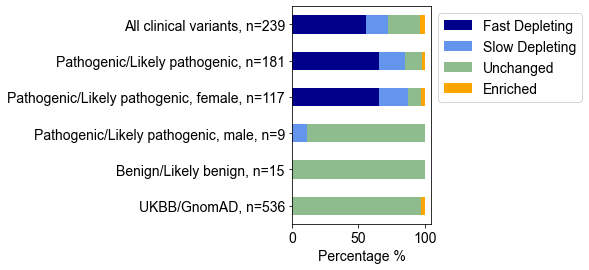

In [71]:
# Identify the proportion of likely/pathogenic and likely/benign variants in each of the SGE functional groups.

clinical = pd.read_csv(data_root+'/DDX3X_sex_agnostic_interpreted_variants.txt', header=0, sep='\t')
print('all_clinical', len(clinical))
FD = clinical.query('SGE_functional_classification == "fast depleting"')
SD = clinical.query('SGE_functional_classification == "slow depleting"')
U = clinical.query('SGE_functional_classification == "unchanged"')
E = clinical.query('SGE_functional_classification == "enriched"')
print('all clinical:', 'depleted', (len(FD)+len(SD)), (len(FD)+len(SD))/len(clinical), 'enriched', len(E), len(E)/len(clinical), len(U), len(U)/len(clinical))
LB_B = clinical.query('pathogenicity == "Benign/Likely_benign"')
LBB_FD = LB_B.query('SGE_functional_classification == "fast depleting"')
LBB_SD = LB_B.query('SGE_functional_classification == "slow depleting"')
LBB_E = LB_B.query('SGE_functional_classification == "enriched"')
LBB_U = LB_B.query('SGE_functional_classification == "unchanged"')
LP_P = clinical.query('pathogenicity == "Pathogenic/Likely_pathogenic"')
LPP_FD = LP_P.query('SGE_functional_classification == "fast depleting"')
LPP_SD = LP_P.query('SGE_functional_classification == "slow depleting"')
LPP_E = LP_P.query('SGE_functional_classification == "enriched"')
LPP_U = LP_P.query('SGE_functional_classification == "unchanged"')
print('Likely path sex agnostic:', len(LP_P),'depleted', (len(LPP_FD)+len(LPP_SD)), (len(LPP_FD)+len(LPP_SD))/len(LP_P), 'enriched', len(LPP_E), len(LPP_E)/len(LP_P), len(LPP_U), len(LPP_U)/len(LP_P))

by_sex=pd.read_csv(data_root+'/DDX3X_path_variants_by_sex.txt', header=0, sep='\t')
LPP_female = by_sex.query('sex == "female" and pathogenicity == "Pathogenic/Likely_pathogenic"')
LPP_female_FD = LPP_female.query('SGE_functional_classification == "fast depleting"')
LPP_female_SD = LPP_female.query('SGE_functional_classification == "slow depleting"')
LPP_female_E = LPP_female.query('SGE_functional_classification == "enriched"')
LPP_female_U = LPP_female.query('SGE_functional_classification == "unchanged"')
print('Likely path female:', len(LPP_female),'depleted', (len(LPP_female_FD)+len(LPP_female_SD)), (len(LPP_female_FD)+len(LPP_female_SD))/len(LPP_female), 'enriched', len(LPP_female_E), len(LPP_female_E)/len(LPP_female), len(LPP_female_U), len(LPP_female_U)/len(LPP_female))

LPP_male = by_sex.query('sex == "male" and pathogenicity == "Pathogenic/Likely_pathogenic"')
LPP_male_FD = LPP_male.query('SGE_functional_classification == "fast depleting"')
LPP_male_SD = LPP_male.query('SGE_functional_classification == "slow depleting"')
LPP_male_E = LPP_male.query('SGE_functional_classification == "enriched"')
LPP_male_U = LPP_male.query('SGE_functional_classification == "unchanged"')
print('Likely path male:', len(LPP_male),'depleted', (len(LPP_male_FD)+len(LPP_male_SD)), (len(LPP_male_FD)+len(LPP_male_SD))/len(LPP_male), 'enriched', len(LPP_male_E), len(LPP_male_E)/len(LPP_male), len(LPP_male_U), len(LPP_male_U)/len(LPP_male))

LPP_male_denovo = by_sex.query('sex == "male" and pathogenicity == "Pathogenic/Likely_pathogenic" and inheritance == "denovo"')
LPP_male_FD_denovo = LPP_male_denovo.query('SGE_functional_classification == "fast depleting"')
LPP_male_SD_denovo = LPP_male_denovo.query('SGE_functional_classification == "slow depleting"')
LPP_male_E_denovo = LPP_male_denovo.query('SGE_functional_classification == "enriched"')
LPP_male_U_denovo = LPP_male_denovo.query('SGE_functional_classification == "unchanged"')

LPP_female_denovo = by_sex.query('sex == "female" and pathogenicity == "Pathogenic/Likely_pathogenic" and inheritance == "denovo"')
LPP_female_FD_denovo = LPP_female_denovo.query('SGE_functional_classification == "fast depleting"')
LPP_female_SD_denovo = LPP_female_denovo.query('SGE_functional_classification == "slow depleting"')
LPP_female_E_denovo = LPP_female_denovo.query('SGE_functional_classification == "enriched"')
LPP_female_U_denovo = LPP_female_denovo.query('SGE_functional_classification == "unchanged"')
print('Likely path denovo female:', len(LPP_female_denovo),'depleted', (len(LPP_female_FD_denovo)+len(LPP_female_SD_denovo)), (len(LPP_female_FD_denovo)+len(LPP_female_SD_denovo))/len(LPP_female_denovo), 'enriched', len(LPP_female_E_denovo), len(LPP_female_E_denovo)/len(LPP_female_denovo), len(LPP_female_U_denovo), len(LPP_female_U_denovo)/len(LPP_female_denovo), '\n\n')

UKBB_GnomAD = not_snvre.query('Population_database =="UKBB_and_GnomAD" or Population_database =="UKBB" or Population_database =="GnomAD"')
UKBB_GnomAD_fastdep = UKBB_GnomAD.query('SGE_functional_classification == "fast depleting"')
UKBB_GnomAD_slowdep = UKBB_GnomAD.query('SGE_functional_classification == "slow depleting"')
UKBB_GnomAD_dep = UKBB_GnomAD.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
UKBB_GnomAD_enriched = UKBB_GnomAD.query('SGE_functional_classification == "enriched"')
UKBB_GnomAD_unchanged = UKBB_GnomAD.query('SGE_functional_classification == "unchanged"')
print('total UKBB GnomAD', len(UKBB_GnomAD), 'unchanged', len(UKBB_GnomAD_unchanged), 'SD', len(UKBB_GnomAD_slowdep), 'E:', len(UKBB_GnomAD_enriched))

with open (out_files+'/D15_Prop_clinical_vars_SGE_functional_classification.txt', 'w') as out:
    header = '\t'.join(['Category', 'Fast Depleting', 'Slow Depleting',  'Unchanged', 'Enriched'])+'\n'
    line1='\t'.join(['All clinical variants, n='+str(len(clinical)), str(100*len(FD)/len(clinical)), str(100*len(SD)/len(clinical)),   str(100*len(U)/len(clinical)), str(100*len(E)/len(clinical))])+'\n'
    line2='\t'.join(['Pathogenic/Likely pathogenic, n='+str(len(LP_P)), str(100*len(LPP_FD)/len(LP_P)), str(100*len(LPP_SD)/len(LP_P)),  str(100*len(LPP_U)/len(LP_P)), str(100*len(LPP_E)/len(LP_P))])+'\n'
    line3='\t'.join(['Pathogenic/Likely pathogenic, female, n='+str(len(LPP_female)), str(100*len(LPP_female_FD)/len(LPP_female)),  str(100*len(LPP_female_SD)/len(LPP_female)),  str(100*len(LPP_female_U)/len(LPP_female)), str(100*len(LPP_female_E)/len(LPP_female))])+'\n'
    line4='\t'.join(['Pathogenic/Likely pathogenic, female, denovo n='+str(len(LPP_female_denovo)), str(100*len(LPP_female_FD_denovo)/len(LPP_female_denovo)),str(100*len(LPP_female_SD_denovo)/len(LPP_female_denovo)),  str(100*len(LPP_female_U_denovo)/len(LPP_female_denovo)), str(100*len(LPP_female_E_denovo)/len(LPP_female_denovo))])+'\n'
    line5='\t'.join(['Pathogenic/Likely pathogenic, male, n='+str(len(LPP_male)), str(100*len(LPP_male_FD)/len(LPP_male)),  str(100*len(LPP_male_SD)/len(LPP_male)),  str(100*len(LPP_male_U)/len(LPP_male)), str(100*len(LPP_male_E)/len(LPP_male))])+'\n'
    line6='\t'.join(['Pathogenic/Likely pathogenic, male, denovo n='+str(len(LPP_male_denovo)), str(100*len(LPP_male_FD_denovo)/len(LPP_male_denovo)),str(100*len(LPP_male_SD_denovo)/len(LPP_male_denovo)),  str(100*len(LPP_male_U_denovo)/len(LPP_male_denovo)), str(100*len(LPP_male_E_denovo)/len(LPP_male_denovo))])+'\n'
    line7='\t'.join(['Benign/Likely benign, n='+str(len(LB_B)), str(100*len(LBB_FD)/len(LB_B)),  str(100*len(LBB_SD)/len(LB_B)), str(100*len(LBB_U)/len(LB_B)), str(100*len(LBB_E)/len(LB_B))])+'\n'
    line8='\t'.join(['UKBB/GnomAD, n=536', str(100*len(UKBB_GnomAD_fastdep)/len(UKBB_GnomAD)), str(100*len(UKBB_GnomAD_slowdep)/len(UKBB_GnomAD)),   str(100*len(UKBB_GnomAD_unchanged)/len(UKBB_GnomAD)), str(100*len(UKBB_GnomAD_enriched)/len(UKBB_GnomAD))])+'\n'
    out.write(header)
    out.write(line8)
    out.write(line7)
    #out.write(line6)
    out.write(line5)
    #out.write(line4)
    out.write(line3)
    out.write(line2)
    out.write(line1)

df = pd.read_csv(out_files+'/D15_Prop_clinical_vars_SGE_functional_classification.txt', '\t')

plt.rcParams["figure.figsize"] = (2.5,4)
df.plot(
    x = 'Category',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['darkblue','cornflowerblue', 'darkseagreen', 'orange'], mark_right = True, fontsize=14)

plt.title('')
plt.xlabel('Percentage %', fontsize=14)
plt.ylabel('', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.savefig(out_files+'/Fig5A_clinical_vars_SGE_functional_classification.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


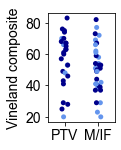

In [72]:
''' Genotype-phenotype analysis

Vineland composite score collated from 3 clinical phenotyping studies is here: data_root+"/Grice_Baker_Lennox_vineland.txt"

'''
phenos = pd.read_csv(data_root+'/Table_S15_NgCordell_Tang_Lennox_Vineland.txt', '\t')
phenos_SGE_depleted_vars = phenos.query('SGE_functional_classification == "fast depleting" or SGE_functional_classification == "slow depleting"')

color_dict={'slow depleting': 'cornflowerblue', 'fast depleting':'darkblue', 'enriched':"orange", 'unchanged':'grey'}
fig,ax = plt.subplots()
fig.set_size_inches(1.2,2)
g=sns.stripplot(data=phenos_SGE_depleted_vars, x='Variant_category', y='Vineland_composite_score', hue = 'SGE_functional_classification', palette=color_dict)
ax.set_xlabel('')
ax.set_xticklabels(['PTV', 'M/IF'], fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel('Vineland composite', fontsize=14)
plt.legend([],[], frameon=False)
plt.savefig(out_files+'/Fig5B_Vineland_PTV_missense.pdf', dpi=1300, bbox_inches='tight', transparent=True)

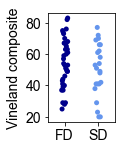

In [73]:
color_dict={'slow depleting': 'cornflowerblue', 'fast depleting':'darkblue', 'enriched':"orange", 'unchanged':'grey'}
fig,ax = plt.subplots()
fig.set_size_inches(1.2,2)
g=sns.stripplot(data=phenos_SGE_depleted_vars, x='SGE_functional_classification', y='Vineland_composite_score', hue = 'SGE_functional_classification', palette=color_dict)
ax.set_xlabel('')
ax.set_xticklabels(['FD', 'SD'], fontsize=14)
ax.set_ylabel('Vineland composite', fontsize=14)
plt.yticks(fontsize=14)
plt.legend([],[], frameon=False)
plt.savefig(out_files+'/Fig5C_Vineland_fast_slow.pdf', dpi=1300, bbox_inches='tight', transparent=True)


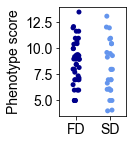

In [74]:
Lennox_scores=pd.read_csv(data_root+'Table_S17_LENNOX_composite_phenotypic_score.txt', '\t')
Lennox_scores_depleted=Lennox_scores.query('SGE_functional_classification == "fast depleting" or SGE_functional_classification=="slow depleting"')

color_dict={'slow depleting': 'cornflowerblue', 'fast depleting':'darkblue'}

fig,ax = plt.subplots()
fig.set_size_inches(1.2,2)
g=sns.stripplot(data=Lennox_scores_depleted, x='SGE_functional_classification', y='Composite_Phenotype_score', hue='SGE_functional_classification', palette=color_dict, ax=ax)
ax.set_xlabel('')
ax.set_xticklabels(['FD', 'SD'], fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel('Phenotype score', fontsize=14)
plt.legend([],[], frameon=False)
plt.savefig(out_files+'/Fig5D_lennox_phenotype_score_fast_slow.pdf', dpi=1300, bbox_inches='tight', transparent=True)


In [75]:
df_walk=pd.read_csv(data_root+'/Table S19_DDD_DDX3X_pt_phenotypes_walking.txt', '\t')
df_talk=pd.read_csv(data_root+'/Table S18_DDD_DDX3X_pt_phenotypes_talking.txt', '\t')
FD_walk = df_walk.query('Sig_cat =="Fast_Depleted"')
SD_walk = df_walk.query('Sig_cat =="Slow_Depleted"')
print('walking, fast depleted', len(FD_walk), 'slow depleted', len(SD_walk))
FD_talk = df_talk.query('Sig_cat =="Fast_Depleted"')
SD_talk = df_talk.query('Sig_cat =="Slow_Depleted"')
print('talking, fast depleted', len(FD_talk), 'slow depleted', len(SD_talk))

walking, fast depleted 31 slow depleted 17
talking, fast depleted 24 slow depleted 16


<function matplotlib.pyplot.show(close=None, block=None)>

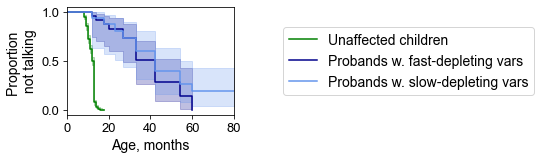

In [76]:
T_talk = df_talk['age_months']
E_talk = df_talk['talking_achieved']

groups = df_talk['Sig_cat']
control = (groups == 'unaffected_children')
fast_depleted=(groups == 'Fast_Depleted')
slow_depleted=(groups == 'Slow_Depleted')

fig,ax = plt.subplots()
fig.set_size_inches(3,2)

kmf.fit(T_talk[control], E_talk[control], label='Unaffected children')
ax = kmf.plot(color='g')

kmf.fit(T_talk[fast_depleted], E_talk[fast_depleted], label='Probands w. fast-depleting vars')
kmf.plot(ax=ax, color='darkblue')

kmf.fit(T_talk[slow_depleted], E_talk[slow_depleted], label='Probands w. slow-depleting vars')
kmf.plot(ax=ax, color='cornflowerblue')

plt.xlim(0,80)
plt.xlabel('Age, months', fontsize=14)
plt.ylabel('Proportion \nnot talking', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
ax.tick_params(axis='y', length=4, labelsize=13)
ax.tick_params(axis='x', length=4, labelsize=13)
plt.savefig(out_files+'/Fig5E_DDD_talking_age_FD_SD.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show


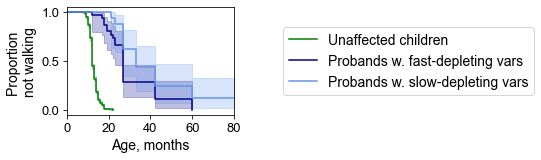

In [77]:
T_walk = df_walk['age_months']
E_walk = df_walk['walking_achieved']

groups = df_walk['Sig_cat']
control = (groups == 'unaffected_children')
fast_depleted=(groups == 'Fast_Depleted')
slow_depleted=(groups == 'Slow_Depleted')

fig,ax = plt.subplots()
fig.set_size_inches(3,2)

kmf.fit(T_walk[control], E_walk[control], label='Unaffected children')
ax = kmf.plot(color='g')

kmf.fit(T_walk[fast_depleted], E_walk[fast_depleted], label='Probands w. fast-depleting vars')
kmf.plot(ax=ax, color='darkblue')

kmf.fit(T_walk[slow_depleted], E_walk[slow_depleted], label='Probands w. slow-depleting vars')
kmf.plot(ax=ax, color='cornflowerblue')

plt.xlim(0,80)
#plt.title("Ages at which children with DDX3X variants walk in the DDD cohort")
plt.xlabel('Age, months', fontsize=14)
plt.ylabel('Proportion \nnot walking', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
ax.tick_params(axis='y', length=4, labelsize=13)
ax.tick_params(axis='x', length=4, labelsize=13)
plt.savefig(out_files+'/Fig5F_DDD_walking_age_FD_SD.pdf', dpi=1300, bbox_inches='tight', transparent=True)
